#### Домашнее задание по теме "ASR для распознавания речи"

ФИО: Червоников Алексей Викторович

#### Загрузка данных

In [2]:
!ls -l /kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav | wc -l

643


Всего существует 643 записи, для которых необоходимо совершить корректный инференс с точки зрения точности по WER.


WER измеряет различие между GT транскрипцией и предсказанной гипотезой на уровне слов. Этот показатель рассчитывается как минимальное количество вставок (I), удалений (D) и замен (S), необходимых для преобразования полученной гипотезы в GT транскрибцию, делённое на общее количество слов в GT транскрипции.
$$WER = \frac{I + D + S}{N},\ N - длина \ GT\ предложения$$

#### Импортируем необходимые модули:

In [1]:
import os
import soundfile as sf
import random
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import string
import librosa
from IPython import display

#### Устанавливаем Seed'ы

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

import warnings
warnings.filterwarnings("ignore")

#### И начинаем! ¡Here we go!

 #### Предварительный анализ данных (без него никак)

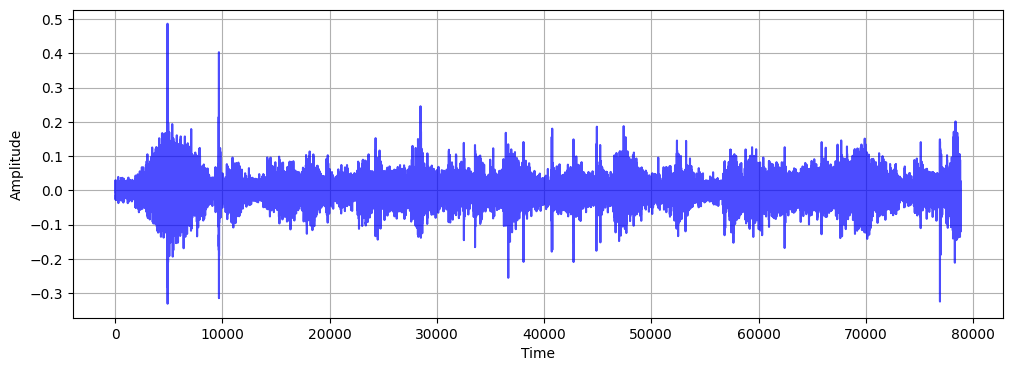

In [4]:
def visualize_audio(wav: torch.Tensor, sr: int = 16000):
    '''Функция, которая визуализиурет аудиозапись как амплитуду сигнала от времени'''
    plt.figure(figsize=(12, 4))
    plt.plot(wav, alpha=.7, c='blue')
    plt.grid()
    plt.xlabel('Time', size=10)
    plt.ylabel('Amplitude', size=10)
    plt.show()
    display.display(display.Audio(wav, rate=sr, normalize=False))

def load_and_visualize_audio(file_path: str = '/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_0.wav',
                            sr: int = 16000):
    '''
    Функция, которая загрузит файл формата .wav, переведет его в вид numpy и затем отобразит

    Параметры:
    -file_path: путь к файлу
    -sr: sampling_rate (частота дискретизации при считывании аудио-сигнала)
    
    '''
    wav, sr = librosa.load(file_path, sr=sr)
    wav = torch.from_numpy(wav)
    if wav.dim() == 2:
        wav = wav.mean(dim=0)
    visualize_audio(wav, sr)

# Выводим plot
load_and_visualize_audio('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav')

Посмотрим на длины последовательностей

In [5]:
def print_seq_lens_info(input_folder: str = '/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav',
                       sr: int = 16000):
    '''
    Функция выведет основную информацию о длинах сигналов из приведенного датасета: min, max, mean.
    (В секундах)
    
    Параметры:
    -input_dir: входная папка с файлами
    -sr: sampling_rate (частота дискретизации при считывании аудио-сигнала)
    '''

    max = 0
    min = float('inf')
    sum = 0
    array_times = []
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)  
        if os.path.isfile(file_path):
            wav, sr = librosa.load(file_path, sr=sr)
            wav = torch.from_numpy(wav)
            if wav.dim() == 2:
                wav = wav.mean(dim=0)
            if (len(wav) / sr) > max:
                max = len(wav) / sr
            if (len(wav) / sr) < min:
                min = len(wav) / sr
            sum += (len(wav) / sr)
            array_times.append((len(wav) / sr))
            
    print(f"Max length of sequence: {max}")
    print(f"Min length of sequence: {min}")
    print(f"Mean length of sequence: {sum / 643 :.2f}")

    return array_times

times = print_seq_lens_info()
    

Max length of sequence: 10.912
Min length of sequence: 0.48
Mean length of sequence: 6.69


Посмотрим на распределение

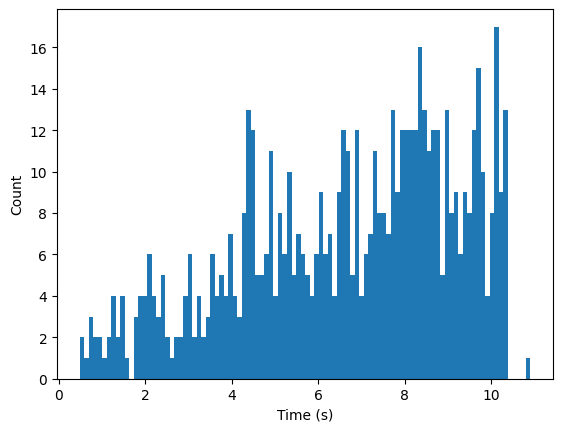

In [6]:
# Отрисовка распределения длин (в секундах)
plt.hist(times, bins = 100)
plt.xlabel("Time (s)")
plt.ylabel("Count")
plt.show()


В целом, ничего особенного в распределении нет. Мы видим, что имеются как длинные, так и небольшие по длине временные последовательности

На основании прослушивания нескольких записей можно сделать вывод, что в некоторых сэмплах имеются наложенные поверх речи звуки (саундтреки к фильмам или в принципе посторонние шумы). Вероятно, модели будет легче выделять и транскрибировать речевые артефакты при остутствии наложенного звука. Для этого можно попробовать воспользоваться инструментами, очищающими речь от посторонних шумов

#### Библиотека noisereduce

Библиотека [noisereduce](https://colab.research.google.com/github/timsainb/noisereduce/blob/master/notebooks/1.0-test-noise-reduction.ipynb#scrollTo=P4jnNIYlBC2F) предназначена для подавления шума в звуковых записях с помощью алгоритмов спектрального вычитания. Она проста в использовании и подходит для задач, где необходимо быстро очистить звук от фонового шума (например, гул, вентиляция, дорожный шум и т.д.).

Работает, используя спектральное вычитание.


Библиотека вычисляет спектр сигнала и вычитает спектр шума.
Спектр шума может быть рассчитан из шумового профиля (например, из начала записи, где слышен только шум).

In [ ]:
pip install noisereduce

In [6]:
from scipy.io import wavfile
import noisereduce as nr

Пример автоматического шумоподавления

In [10]:
file_path = '/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav'
sr = 16000
audio, sr = librosa.load(file_path, sr=sr)

reduced_noise_auto = nr.reduce_noise(y=audio, sr=sr)
display.display(display.Audio(reduced_noise_auto, rate=sr, normalize=True))

Мы видим, что посторонние звуки действительно приглушаются.

В отличии от ручного шумоподавления, автоматическое под капотом (как я понял) выбирает отрезок тишины и анализирует его спектрограмму. Ручное же подразумевает самостоятельный выбор отрезка предполагаемого шума (например какое-то мгновенье в начале).

Поскольку в нашем случае речь может начинаться прямо сначала, поэтому выбирать вручную шумовой интервал может быть рисковано и неэффективно.

#### Нейросетевые подходы

Существуют обученные модели для проведения фильтрации звука на стадии препроцессинга. Попробуем применить и их!

#### Spleeter

[Spleeter](https://github.com/deezer/spleeter) - инструмент с открытым исходным кодом, разработанный компанией Deezer, для разделения аудиотреков на отдельные звуковые компоненты (стемы). Например, он позволяет извлечь голос (вокал) из аудиотрека, отделив его от инструментального сопровождения. Этот инструмент широко используется в задачах, связанных с обработкой звука, таких как улучшение качества записи, создание караоке, обработка данных для задач машинного обучения.

Spleeter предоставляет предобученные модели, что делает его готовым к использованию «из коробки».

Как удалось выяснить, данный инструмент подходит в основном для выделения вокала и аккомпонемента, поэтому и получаются строчки:

```python
vocals = prediction['vocals']
accompaniment = prediction['accompaniment']
```

In [254]:
from spleeter.audio.adapter import AudioAdapter
from spleeter.separator import Separator

separator = Separator('spleeter:2stems')

audio_loader = AudioAdapter.default()
waveform, sample_rate = audio_loader.load('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav', sample_rate=16000)

prediction = separator.separate(waveform)

vocals = prediction['vocals']
accompaniment = prediction['accompaniment']

In [255]:
import soundfile as sf
from IPython.display import Audio

sf.write('vocals.wav', vocals, sr)

Audio('vocals.wav')

В целом, особой разницы не чувствуется с обычным подходом. При этом разделение не всегда корректно отрабатывает.

#### SpeechBrain

Нейросетевой подход для выделения сигналов из посторонних звуков

In [137]:
from speechbrain.inference.separation import SepformerSeparation as separator
import torchaudio
from IPython.display import Audio

Загрузка модели

In [138]:
model = separator.from_hparams(source="speechbrain/sepformer-wham16k-enhancement", savedir='pretrained_models/sepformer-wham16k-enhancement')

hyperparams.yaml:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

In [164]:
audio_sources = model.separate_file(path='/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_7.wav')
reduced_noise_auto = nr.reduce_noise(y=audio_sources[:, :, 0], sr=sr)
print("After NN, then reduce noise")
display.display(display.Audio(reduced_noise_auto, rate=sr, normalize=True))

print("After NN only")
display.display(display.Audio(audio_sources[:, :, 0], rate=sr, normalize=False))

After NN, then reduce noise


After NN only


In [179]:
from speechbrain.pretrained import SepformerSeparation as separator

# Загрузка модели для разделения речи и шума
separator = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir="tmpdir")

# Разделение аудиофайла на речь и шум
est_sources = separator.separate_file(path="/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_10.wav")

Resampling the audio from 16000 Hz to 8000 Hz


In [181]:
print("After NN only")
display.display(display.Audio(est_sources[:, :, 0], rate=8000, normalize=True))

After NN only


На некоторых сэмплах качество записей мягко говоря оставляет желать лучшего... Ожидания были завышены(

Возможно есть смысл повозиться с Фурье анализом и задействовать фильтры частот

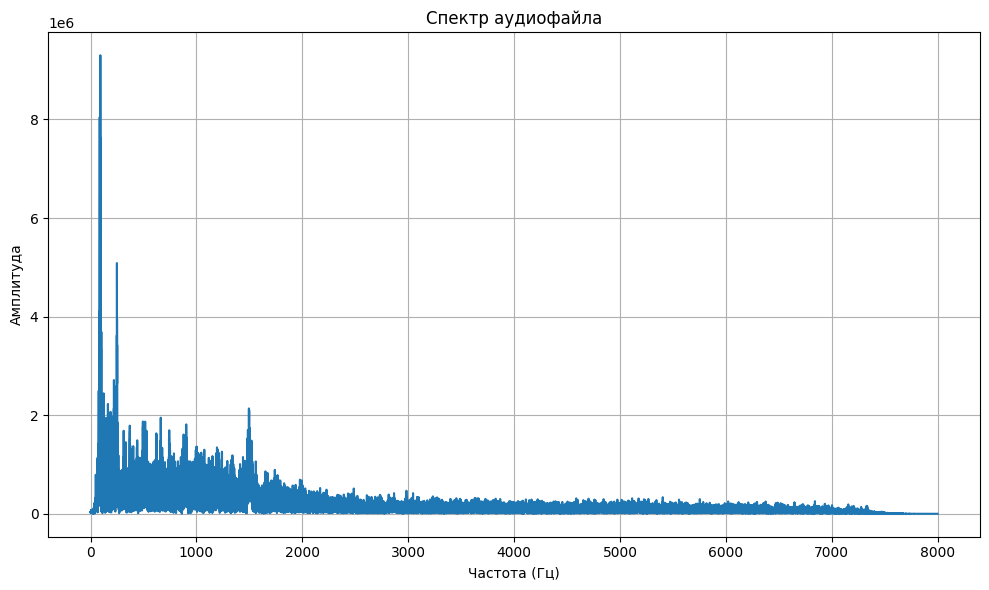

In [249]:
from scipy.io import wavfile

rate, data = wavfile.read('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav')

# Если стерео данные
if len(data.shape) > 1:
    data = data.mean(axis=1)

# БПФ
n = len(data)
frequencies = np.fft.fftfreq(n, 1 / rate)  # Частоты
spectrum = np.fft.fft(data)  # FFT спектр

# Амплитуда спектра
amplitude = np.abs(spectrum)

plt.figure(figsize=(10, 6))
plt.plot(frequencies[:n // 2], amplitude[:n // 2])  
plt.title('Спектр аудиофайла')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.tight_layout()
plt.show()


Применение полосового фильтра

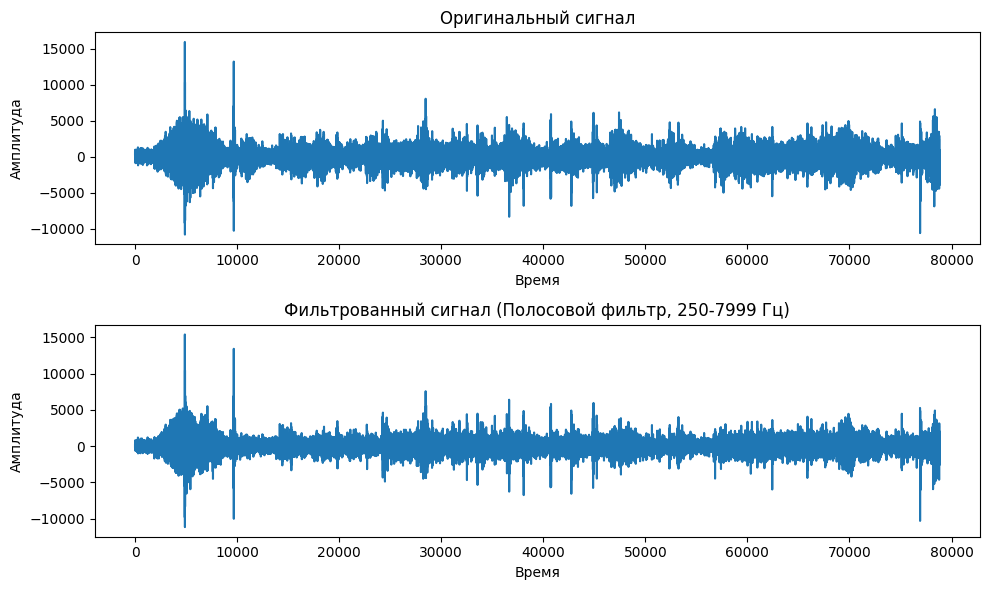

In [267]:
from scipy.signal import butter, filtfilt

# Полосовой фильтр
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

rate, data = wavfile.read('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav')

# Если стерео
if len(data.shape) > 1:
    data = data.mean(axis=1)

# Частоты среза
lowcut = 250  # нижняя частота среза
highcut = 7999 # верхняя частота среза

filtered_signal = bandpass_filter(data, lowcut, highcut, rate) 


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title('Оригинальный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(2, 1, 2)
plt.plot(filtered_signal)
plt.title(f'Фильтрованный сигнал (Полосовой фильтр, {lowcut}-{highcut} Гц)')
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.tight_layout()
plt.show()

Слушаем

In [268]:
display.display(display.Audio(filtered_signal, rate=16000, normalize=True))

In [269]:
reduced_noise_auto_filtered = nr.reduce_noise(y=filtered_signal, sr=sr)
display.display(display.Audio(reduced_noise_auto_filtered, rate=16000, normalize=True))

Возможно, существует какой-то дополнительный математический аппарат для оценки качества работы различных методов денойзинга, однако на слух чётче и лучше воспринимается комбинация bandbass_filter(lowcut = 250 Гц, highcut = max_freq) + nr.reduce_noise(auto). По крайней мере такая эвристика неплохо подчищает зашумлённую запись ./wav/audio_20.wav

Итак, поскольку решено применить именно такую эвристику, то необходимо объявить функцию-пайплайн препроцессинга сэмпла

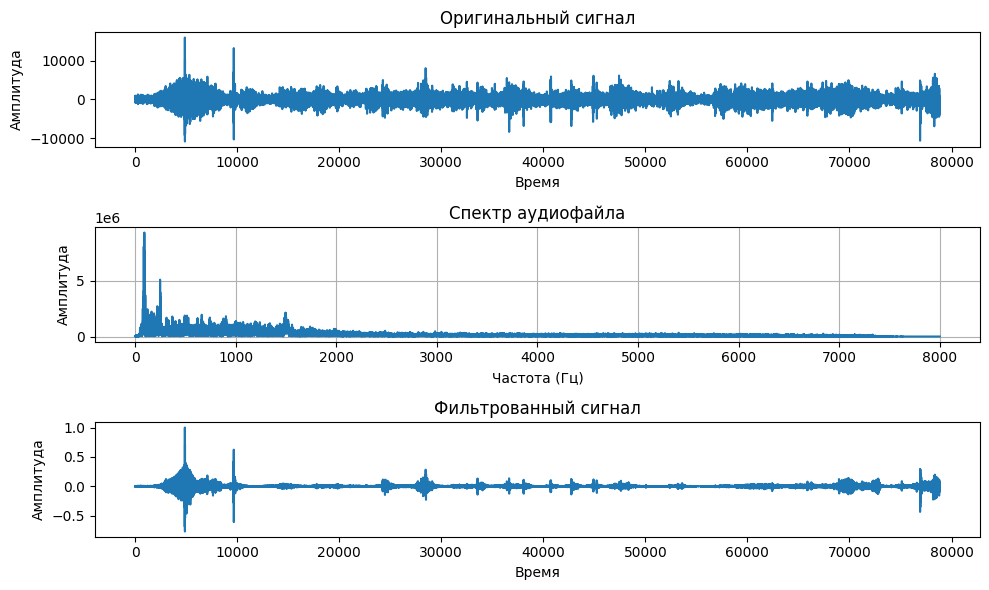

In [8]:
from scipy.signal import butter, filtfilt
sr = 16000

# Полосовой фильтр (Объявим еще раз, чтобы всё было в одном месте)
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    '''Полосовой фильтр Баттерворта 4-ого порядка'''
    nyquist = 0.5 * fs # С учетом теоремы Котельникова
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def bandpass_filter_noise_reducer(input_file = '/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav',
                                 lowcut = 250,
                                 highcut = 7999,
                                 normalize_signal = True,
                                 plot = False):
        '''
        Функция, фильтрующая аудиосигнал при помощи полосового фильтра и спектрального вычитания

        Параметры: 
        -input_file: .wav файл с аудио-сигналом
        -lowcut: нижняя частота среза (default: 250 Гц)
        -highcut: верхняя частота среза (default: 7999 Гц)
        -normalize_signal: флаг нормализации сигнала (default: True)
        -plot: флаг отрисовки графиков и вывода интерфейса для play (default: False)

        Возвращает отфильтрованный аудио-сигнал
        '''
        rate, signal = wavfile.read(input_file)

        # Если стерео файл
        if len(signal.shape) > 1:
            data = signal.mean(axis=1)

        # Частоты среза
        lowcut = 250  # нижняя частота среза
        highcut = 7999 # верхняя частота среза
        
        filtered_signal = bandpass_filter(signal, lowcut, highcut, rate)
        reduced_noise_auto_filtered = nr.reduce_noise(y=filtered_signal, sr=sr)

        if normalize_signal:
            max_val = np.max(np.abs(reduced_noise_auto_filtered))
            reduced_noise_auto_filtered = reduced_noise_auto_filtered / max_val  

        if plot:

            # БПФ
            n = len(signal)
            frequencies = np.fft.fftfreq(n, 1 / rate)  # Частоты
            spectrum = np.fft.fft(signal)  # FFT спектр
            
            # Амплитуда спектра
            amplitude = np.abs(spectrum)
            
            plt.figure(figsize=(10, 6))
            plt.subplot(3, 1, 1)
            plt.plot(signal)
            plt.title('Оригинальный сигнал')
            plt.xlabel('Время')
            plt.ylabel('Амплитуда')

            plt.subplot(3, 1, 2)
            plt.plot(frequencies[:n // 2], amplitude[:n // 2])  
            plt.title('Спектр аудиофайла')
            plt.xlabel('Частота (Гц)')
            plt.ylabel('Амплитуда')
            plt.grid(True)
            plt.tight_layout()
            
            
            plt.subplot(3, 1, 3)
            plt.plot(reduced_noise_auto_filtered)
            plt.title(f'Фильтрованный сигнал')
            plt.xlabel('Время')
            plt.ylabel('Амплитуда')
            
            plt.tight_layout()
            plt.show()

            display.display(display.Audio(reduced_noise_auto_filtered, rate=16000, normalize=True))

        return reduced_noise_auto_filtered


filtered_input_signal = bandpass_filter_noise_reducer(plot = True)

Итак, первичный анализ закончен. Возможно, найду ещё что-нибудь, но пока остановимся на алгоритмической фильтрации без использования Deep Learning методов.

#### Inference

Начинаем экспериментировать с моделями. Посмотрим, как предсказание Whisper Baseline отличается в зависимости от подачи сырых/отфильтрованных данных

Импортируем модель

In [14]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

device = "cuda:0"
model_name = "openai/whisper-base"
processor = WhisperProcessor.from_pretrained(model_name)
processor.feature_extractor.return_attention_mask = True
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

#### Baseline подход

In [10]:
def batch_inference(model, 
                    processor, 
                    path_to_wavs, 
                    batch_size, 
                    sampling_rate=16000, 
                    filter = True):
    results = {}
    wav_files = os.listdir(path_to_wavs)

    forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe") # generates task specific special tokens

    for i in tqdm(range(0, len(wav_files), batch_size), total=np.ceil(len(wav_files) / batch_size)):
        audio_paths = wav_files[i : i + batch_size]

        batch = []

        for path in audio_paths:
            if not filter:
                audio, _ = sf.read(os.path.join(path_to_wavs, path))
                # print(len(audio))
            else:
                audio = bandpass_filter_noise_reducer(os.path.join(path_to_wavs, path), 
                                                      normalize_signal = True)
            # break
            batch.append(audio)
        inputs = processor(batch, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

        x, x_masks = inputs["input_features"].to(device), inputs["attention_mask"].to(device)
        # break
        with torch.no_grad():
            model.eval()
            output_ids = model.generate(x, forced_decoder_ids=forced_decoder_ids, attention_mask=x_masks)

        transcribtion = processor.batch_decode(output_ids, skip_special_tokens=True)

        results.update(zip(audio_paths, transcribtion))
    return results

Объявляем batch_size и расположение файлов

In [43]:
path_to_wavs = "/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav"
batch_size = 64

Пробуем запустить инференс и посмотрим на результаты

Начинаем с фильтрованными данными

In [44]:
results_filtered = batch_inference(model=model, 
                          processor=processor, 
                          path_to_wavs=path_to_wavs, 
                          batch_size=batch_size,
                          filter = True)

100%|██████████| 11/11.0 [02:47<00:00, 15.19s/it]


In [46]:
results_filtered['audio_7.wav']

' Я в топ-30 обматал темс-2.'

Теперь с сырыми

In [47]:
results_classic = batch_inference(model=model, 
                          processor=processor, 
                          path_to_wavs=path_to_wavs, 
                          batch_size=batch_size,
                          filter = False)

100%|██████████| 11/11.0 [01:28<00:00,  8.04s/it]


In [48]:
results_classic['audio_7.wav']

' Я в топ-30 обатал тем с два.'

Различия имеются

In [49]:
results_classic['audio_20.wav']

' Девушка.'

In [50]:
results_filtered['audio_20.wav']

' Я...'

Ground truth

In [59]:
wav, sr = librosa.load('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_20.wav', sr=16000)
wav = torch.from_numpy(wav)
if wav.dim() == 2:
    wav = wav.mean(dim=0)

display.display(display.Audio(wav, rate=sr, normalize=False))

In [51]:
results_classic['audio_25.wav']

' Всем саламата Карпатыч, салент запоздания.'

In [52]:
results_filtered['audio_25.wav']

' Всем саламата Карпатыч, сарензопоздание!'

In [60]:
wav, sr = librosa.load('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_25.wav', sr=16000)
wav = torch.from_numpy(wav)
if wav.dim() == 2:
    wav = wav.mean(dim=0)

display.display(display.Audio(wav, rate=sr, normalize=False))

In [66]:
results_classic['audio_29.wav']

' Да, конечно, пацаны мне лишь бы возможность, я вывезу, вывезу. Окей, тогда на связи сообщу чукак. До свидания.'

In [65]:
results_filtered['audio_29.wav']

' Да, конечно, официально не ешь бы возможности, я бы и без вывезу.'

In [67]:
wav, sr = librosa.load('/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav/audio_29.wav', sr=16000)
wav = torch.from_numpy(wav)
if wav.dim() == 2:
    wav = wav.mean(dim=0)

display.display(display.Audio(wav, rate=sr, normalize=False))

В общем, где-то фильтр лучше, где-то хуже по ощущениям. Будем пробовать более крутые модели

В принципе, предоубченные сети задействуют полный диапазон частот, поэтому урезание по нижней границе в особенности может быть излишним и запутать модель с точки зрения понимания спектрограммы.

Перед инференсом моделей объявим интструменты для получения submit.csv файла

In [19]:
def dummy_postprocessing(data):
    for filename, hypo in data.items():
        hypo = hypo.strip()
        hypo = hypo.translate(str.maketrans('', '', string.punctuation))
        hypo = hypo.lower()
        data[filename] = hypo
    return data

In [23]:
def make_submit_csv(results):
    clean_data = dummy_postprocessing(results)
    sample_submission = pd.read_csv("/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/sample_submission.csv")
    sample_submission["hypo"] = sample_submission["filename"].apply(lambda x: clean_data[x])
    sample_submission.insert(0, "id", sample_submission.index)
    return sample_submission

Не мелочимся и пробуем whisper-large модель

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

device = "cuda:0"
model_name = "openai/whisper-large-v3"
processor = WhisperProcessor.from_pretrained(model_name)
processor.feature_extractor.return_attention_mask = True
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

Загрузили, теперь запускаем инференс

In [12]:
path_to_wavs = "/kaggle/input/vk-edu-bmstu-asr-competition/kaggle/wav"
batch_size = 2

In [14]:
results_classic_large = batch_inference(model=model, 
                          processor=processor, 
                          path_to_wavs=path_to_wavs, 
                          batch_size=batch_size,
                          filter = False)

100%|██████████| 321/321.0 [10:04<00:00,  1.88s/it]


In [15]:
results_classic_large['audio_7.wav']

' Я в топ-30 по Battle Teams 2.'

In [16]:
results_classic_large['audio_20.wav']

' Девушка, спасибо.'

In [17]:
results_classic_large['audio_25.wav']

' Всем салам, это Карпатыч. Сорян за опоздание.'

In [18]:
results_classic_large['audio_29.wav']

' Да, конечно. Пацаны, мне лишь бы возможность. Я вывезу, вывезу. Окей, тогда на связи сообщу, что как. До свидания.'

Как бы сказал футбольный комментатор: "Сразу видна разница в классе!". Сохраняем модель, чтобы ничего не потерять.

In [27]:
result_submission_large_whisper_classic = make_submit_csv(results_classic_large)
result_submission_large_whisper_classic.to_csv("result_submission_large_whisper_classic.csv", index=False)

In [26]:
result_submission_large_whisper_classic.head()

,id,filename,hypo
0,0,audio_0.wav,продолжение следует
1,1,audio_1.wav,субтитры сделал dimatorzok
2,2,audio_2.wav,потише жрем враг на гремле сюда и тесто жрать
3,3,audio_3.wav,слышали не понял
4,4,audio_4.wav,быстро за мной


Теперь пробуем фильтрованные данные

In [28]:
results_filtered_large = batch_inference(model=model, 
                          processor=processor, 
                          path_to_wavs=path_to_wavs, 
                          batch_size=batch_size,
                          filter = True)

100%|██████████| 321/321.0 [10:45<00:00,  2.01s/it]


In [29]:
results_filtered_large['audio_7.wav']

' Я в топ-30 по Battle Teams 2.'

In [30]:
results_filtered_large['audio_20.wav']

' Девушка.'

In [31]:
results_filtered_large['audio_25.wav']

' Всем салам, это Карпатыч, сорян за опоздание.'

In [32]:
results_filtered_large['audio_29.wav']

' Да, конечно. Пацаны, мне лишь бы возможность. Я вывезу, вывезу. Окей, тогда на связи сообщу, чё как. До свидания.'

А тут фильтрация наоборот симпатично смотрится. Сохраняем

In [33]:
result_submission_large_whisper_filtered = make_submit_csv(results_filtered_large)
result_submission_large_whisper_filtered.to_csv("result_submission_large_whisper_filtered.csv", index=False)

In [34]:
result_submission_large_whisper_filtered.head()

,id,filename,hypo
0,0,audio_0.wav,субтитры сделал dimatorzok
1,1,audio_1.wav,субтитры создавал dimatorzok
2,2,audio_2.wav,вот тише жрём как и гремлин
3,3,audio_3.wav,ну что летим ну и что
4,4,audio_4.wav,быстро за мной
